 ### Step 0: Import Libraries

In [1]:
# Step 0: Import Stuff

import torch
import torch.nn as nn
import torch.nn.functional as F          # adds some efficiency
from torch.utils.data import DataLoader  # lets us load data in batches
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix  # for evaluating results
import matplotlib.pyplot as plt
%matplotlib inline

### Step 1: Get Data with Transform

In [2]:
# Step 1: Define transform and Get Data

transform = transforms.ToTensor()
train_data = datasets.MNIST(root='../Data', train = True, download = True, transform = transform)
test_data = datasets.MNIST(root='../Data', train = False, download = True, transform = transform)

print(train_data)
print("\n")
print(test_data)

100%|██████████| 9.91M/9.91M [00:00<00:00, 11.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 334kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.18MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.71MB/s]

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()


Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [3]:
len(train_data[0])

2

In [4]:
image, label = train_data[0]
print("Image shape: ", image.shape, "\nLabel: ", label)

Image shape:  torch.Size([1, 28, 28]) 
Label:  5


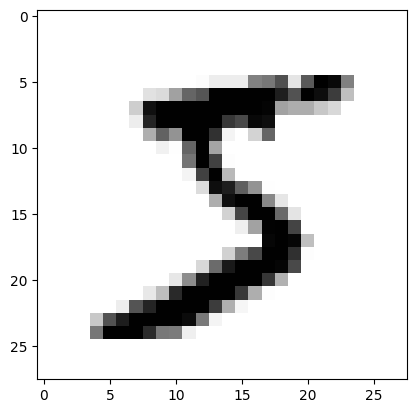

In [5]:
plt.imshow(image.view(28,28), cmap="gist_yarg")

### Step 2: Load Data into DataLoader

In [6]:
# Set Seed for Consistent Results

torch.manual_seed(101)
train_loader = DataLoader(train_data, batch_size = 100, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 500, shuffle = True)

len(train_loader) # ie. 600 loads of 100 images each = 60,000 images

600

In [7]:
# Load the first batch, print its shape
for images, labels in train_loader:
    print('Batch shape:', images.size())
    break
    
# EQUIVALENT TO:
# dataiter = iter(train_loader)
# images, labels = dataiter.next()
# print('Batch shape:', images.size())

Batch shape: torch.Size([100, 1, 28, 28])


### Step 3: Train Model

In [8]:
class MultiLayerPerceptron(nn.Module):
    
    def __init__(self, input_size = 28*28, output_size = 10, layers = [120, 84]):
       
        super().__init__()
        self.fully_connected_1 = nn.Linear(input_size, layers[0])
        self.fully_connected_2 = nn.Linear(layers[0], layers[1])
        self.fully_connected_3 = nn.Linear(layers[1], output_size)
        
    def forward(self, X):
        
        X = F.relu(self.fully_connected_1(X))
        X = F.relu(self.fully_connected_2(X))
        X = self.fully_connected_3(X)
        
        return F.log_softmax(X, dim = 1)

In [9]:
torch.manual_seed(101)
model = MultiLayerPerceptron()
print(model)

MultiLayerPerceptron(
  (fully_connected_1): Linear(in_features=784, out_features=120, bias=True)
  (fully_connected_2): Linear(in_features=120, out_features=84, bias=True)
  (fully_connected_3): Linear(in_features=84, out_features=10, bias=True)
)


In [10]:
for name, param in model.named_parameters():
    print(f"{name} : {param.shape}")

fully_connected_1.weight : torch.Size([120, 784])
fully_connected_1.bias : torch.Size([120])
fully_connected_2.weight : torch.Size([84, 120])
fully_connected_2.bias : torch.Size([84])
fully_connected_3.weight : torch.Size([10, 84])
fully_connected_3.bias : torch.Size([10])


In [11]:
# (120*784) + 120 + (84*120) + 84 + (10*84) + 10
print(sum(p.numel() for p in model.parameters()))

105214


### Step 4: Define LossFunction & Optimizer

#### Loss Function:
- Measures difference between predicted logits and true values

#### Optimizer:
- Changes model's weight(W) to reduce loss *(using gradient descent)*

In [12]:
lossFunction = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

### Step 5: Train Model

| Without `torch.no_grad()` | With `torch.no_grad()`    |
| ------------------------- | ------------------------- |
| Gradients tracked         | No gradients tracked      |
| More memory use           | Less memory use           |
| Slower                    | Faster                    |
| Used in training          | Used in testing/inference |

In [13]:
import time
start_time = time.time()

epochs = 8

train_loss = []
train_correct = []

validation_loss = []
validation_correct = []

for i in range(epochs):
    
    print("epoch: ", i)
    
    trn_correct = 0
    
    # TRAIN
    
    for iteration, (train_image, train_label) in enumerate(train_loader):
        
        iteration += 1
        
        # apply model
        predicted_label = model(train_image.view(100, -1)) # 100 x [0.1, 3.5, , ,..(10)]
        loss = lossFunction(predicted_label, train_label)
        
        # update params
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # tally
        predicted = predicted_label.argmax(dim=1)  # (x100) cleaner and preferred
        trn_correct += (predicted == train_label).sum() # counts how many true

    train_correct.append(trn_correct.item())
    train_loss.append(loss.item())
    print("train\naccuracy: ", trn_correct.item()*100/60_000, "\nloss: ", loss.item())
        
    # TEST
    
    val_correct = 0
    
    with torch.no_grad():
        for iteration, (test_image, test_label) in enumerate(test_loader):

            # apply the model
            label_value = model(test_image.view(500, -1)) # 500 1-D Tensors[10] of logits probabilities
            
            # tally
            predicted = label_value.argmax(dim=1)  # (x100) cleaner and preferred
            val_correct += (predicted == test_label).sum() # counts how many true
    
    loss = lossFunction(label_value, test_label)
    validation_loss.append(loss.item())
    validation_correct.append(val_correct.item())
    print("test\naccuracy: ", val_correct.item()*100/10_000, "\nloss: ", loss.item(), "\n\n")
            
        
end_time = time.time()
print("elapsed time: ", end_time - start_time, "sec")

epoch:  0
train
accuracy:  89.57333333333334 
loss:  0.13651518523693085
test
accuracy:  94.36 
loss:  0.1471690833568573 


epoch:  1
train
accuracy:  95.385 
loss:  0.07247371971607208
test
accuracy:  96.13 
loss:  0.12573491036891937 


epoch:  2
train
accuracy:  96.73666666666666 
loss:  0.1213008239865303
test
accuracy:  96.56 
loss:  0.11164728552103043 


epoch:  3
train
accuracy:  97.445 
loss:  0.0714283287525177
test
accuracy:  97.36 
loss:  0.04665723443031311 


epoch:  4
train
accuracy:  98.09166666666667 
loss:  0.11627047508955002
test
accuracy:  97.26 
loss:  0.1052810549736023 


epoch:  5
train
accuracy:  98.48 
loss:  0.03452489897608757
test
accuracy:  97.27 
loss:  0.0901423990726471 


epoch:  6
train
accuracy:  98.62333333333333 
loss:  0.0703059732913971
test
accuracy:  97.43 
loss:  0.07405849546194077 


epoch:  7
train
accuracy:  98.98 
loss:  0.09827862679958344
test
accuracy:  97.79 
loss:  0.11145572364330292 


elapsed time:  80.46145129203796 sec


### Step 6: Evaluate Test Data
- まかしとくわ

<function matplotlib.pyplot.show(close=None, block=None)>

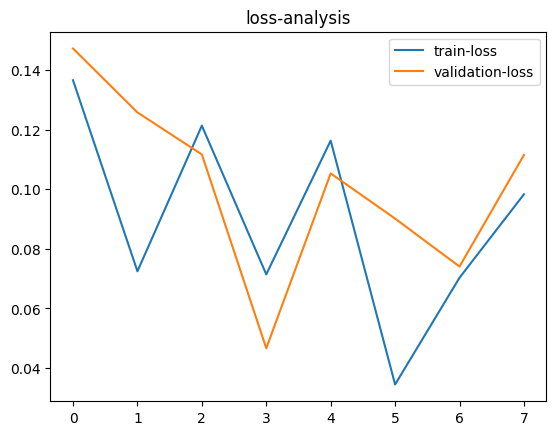

In [14]:
plt.figure("loss-analysis")
plt.plot(train_loss, label = "train-loss")
plt.plot(validation_loss, label = "validation-loss")
plt.legend()
plt.title("loss-analysis")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

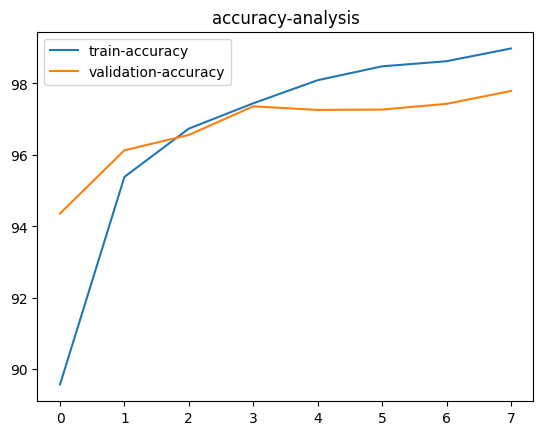

In [15]:
plt.figure("accuracy-analysis")
plt.plot([t*100/60000 for t in train_correct], label = "train-accuracy")
plt.plot([t*100/10000 for t in validation_correct], label = "validation-accuracy")
plt.legend()
plt.title("accuracy-analysis")
plt.show

In [16]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), test_label.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[  43    0    0    0    0    0    1    1    1    0]
 [   0   51    0    0    0    0    0    0    0    0]
 [   0    0   42    0    0    0    0    0    0    0]
 [   0    0    0   43    0    1    0    0    0    0]
 [   0    0    0    0   57    0    0    1    1    1]
 [   0    0    0    0    0   48    0    0    1    1]
 [   0    0    0    0    0    0   50    0    0    0]
 [   0    0    0    0    0    0    0   43    1    0]
 [   0    0    1    0    0    0    0    0   51    0]
 [   0    0    0    0    2    1    0    1    0   57]]
